In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [5]:
path = "dataset/arima.xlsx"

In [7]:
data = pd.read_excel(path)

In [8]:
def convert_date(x,y,z):
  orig_date = datetime(x,y,z)
  orig_date = str(orig_date)
  d = datetime.strptime(orig_date, '%Y-%m-%d %H:%M:%S')
  return d

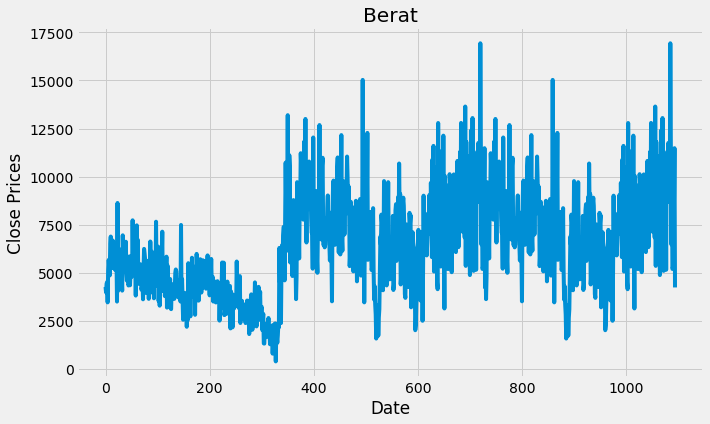

In [9]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Berat')
plt.plot(data['berat'])
plt.title('Berat')
plt.show()

In [10]:
data = pd.read_excel(path ,sheet_name=0, index_col='tanggal', parse_dates=['tanggal'],).fillna(0)
data

,berat
tanggal,
2017-01-01,4266
2017-01-02,3986
2017-01-03,4434
2017-01-04,4525
2017-01-05,3467
...,...
2019-12-27,5265
2019-12-28,6100
2019-12-29,8485


In [11]:
data.describe()

,berat
count,1095.000000
mean,6467.713242
std,2576.778724
min,401.000000
25%,4508.000000
50%,6321.000000
75%,8251.000000
max,16929.000000


<AxesSubplot:ylabel='Density'>

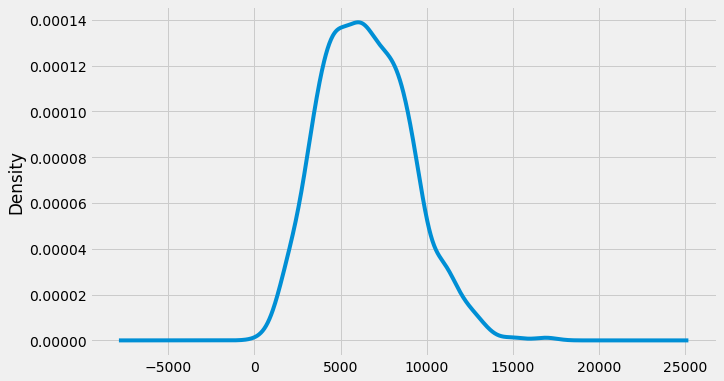

In [12]:
# memvisualisasikan data dalam seri melalui distribusi probabilitas
data.berat.plot(kind='kde')

In [ ]:
"""deret waktu tertentu diperkirakan terdiri dari tiga komponen sistematis termasuk level, tren, musiman, dan satu komponen non-sistematis yang disebut kebisingan.

Komponen-komponen ini didefinisikan sebagai berikut:

Level: Nilai rata-rata dalam seri.

Trend: Nilai naik atau turun dalam deret.

Musiman: Siklus jangka pendek yang berulang dalam seri.

Kebisingan: Variasi acak dalam seri.

Pertama, kita perlu memeriksa apakah suatu deret stasioner atau tidak karena analisis deret waktu hanya bekerja dengan data stasioner.

Tes ADF (Augmented Dickey-Fuller)

Tes Dickey-Fuller adalah salah satu tes statistik yang paling populer. Ini dapat digunakan untuk menentukan keberadaan akar satuan dalam deret, dan karenanya membantu kita memahami apakah deret itu stasioner atau tidak. Hipotesis nol dan alternatif dari tes ini adalah:

Hipotesis Null: Deret memiliki akar satuan (nilai a = 1)

Hipotesis Alternatif: Deret tidak memiliki akar satuan.

Jika kita gagal menolak hipotesis nol, kita dapat mengatakan bahwa deret tersebut tidak stasioner. Ini berarti bahwa deret tersebut dapat linier atau stasioner beda.

Jika mean dan standar deviasi keduanya adalah garis datar (rata-rata konstan dan varians konstan), deret tersebut menjadi stasioner.

**Jadi mari kita periksa stasioneritasnya:"""

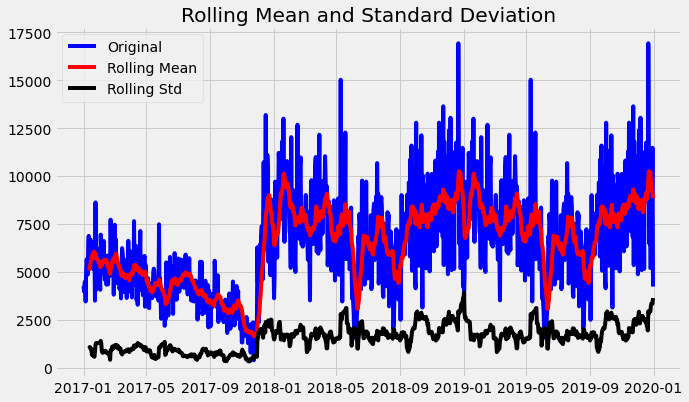

Results of dickey fuller test
Test Statistics                  -2.551752
p-value                           0.103385
No. of lags used                 21.000000
Number of observations used    1073.000000
critical value (1%)              -3.436459
critical value (5%)              -2.864237
critical value (10%)             -2.568206
dtype: float64


In [13]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(data)

In [ ]:
"""Melalui grafik di atas, kita dapat melihat peningkatan mean dan standar deviasi sehingga deret kita tidak stasioner.

Kami melihat bahwa nilai p lebih besar dari 0,05 sehingga kami tidak dapat menolak hipotesis Null. Juga, statistik uji lebih besar dari nilai kritis. sehingga data tersebut tidak stasioner.

Untuk melakukan analisis deret waktu, kita mungkin perlu memisahkan musim dan tren dari deret kita. Deret yang dihasilkan akan menjadi stasioner melalui proses ini.

Jadi kita pisahkan Tren dan Musiman dari deret waktu."""

<Figure size 720x432 with 0 Axes>

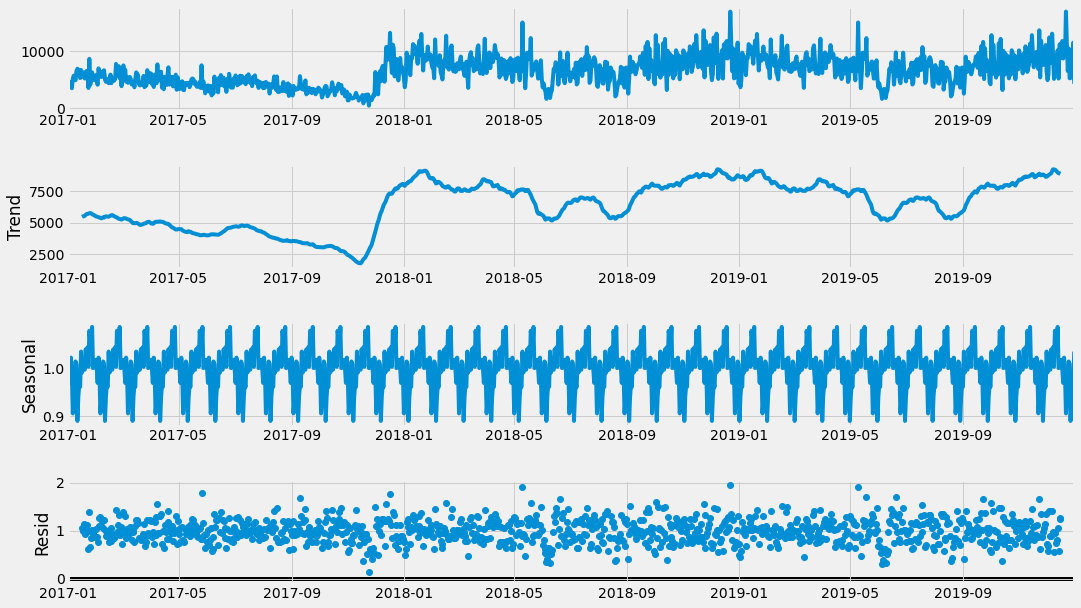

In [14]:
#Untuk memisahkan tren dan musiman dari deret waktu,
# kita dapat menguraikan seri menggunakan kode berikut.
result = seasonal_decompose(data, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

In [ ]:
'''mulai dengan mengambil log dari rangkaian tersebut untuk mengurangi besarnya 
nilai dan mengurangi tren naik dalam rangkaian tersebut. Kemudian setelah mendapatkan log dari seri, 
kami menemukan rata-rata bergulir dari seri. Rata-rata bergulir dihitung dengan mengambil input selama 12 bulan 
terakhir dan memberikan nilai konsumsi rata-rata pada setiap titik yang lebih maju secara seri.'''

No handles with labels found to put in legend.


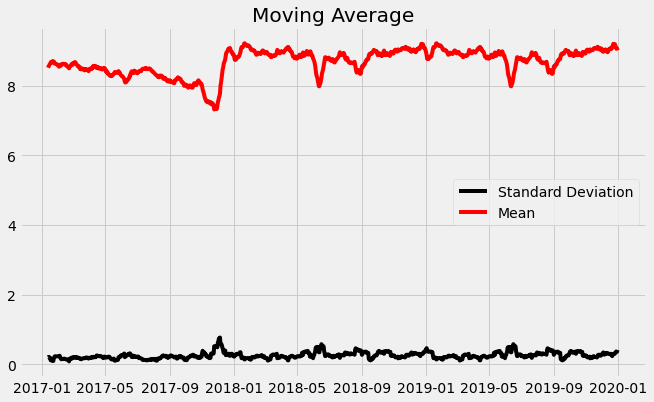

In [15]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(data)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

In [ ]:
"""Sekarang  membuat model ARIMA dan akan
melatihnya. 
Jadi pisahkan data menjadi set pelatihan dan pengujian dan 
memvisualisasikannya."""

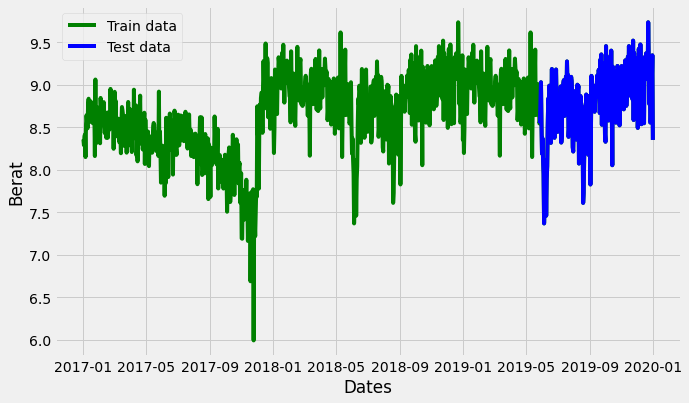

In [16]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.8)], df_log[int(len(df_log)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Berat')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [ ]:
'''Saatnya memilih parameter p,q,d untuk model ARIMA. 
Terakhir kali kita memilih nilai p,d, dan q dengan mengamati plot ACF dan PACF.

menggunakan Auto ARIMA untuk mendapatkan parameter terbaik bahkan tanpa memplot 
grafik ACF dan PACF.

Auto ARIMA: Secara otomatis menemukan urutan optimal untuk model ARIMA.
Fungsi auto_arima berusaha mengidentifikasi parameter paling optimal untuk model ARIMA, 
dan mengembalikan model ARIMA yang sesuai. Fungsi ini didasarkan pada fungsi R yang umum digunakan, 
forecast::auto.arima.

Fungsi auro_arima bekerja dengan melakukan tes differencing (yaitu, Kwiatkowski–Phillips–Schmidt–Shin, 
Augmented Dickey-Fuller atau Phillips–Perron) untuk menentukan urutan differencing, d, 
dan kemudian memasang model dalam rentang start_p, max_p, start_q yang ditentukan , rentang max_q. 
Jika pilihan musiman diaktifkan, auto_arima juga berusaha mengidentifikasi parameter hiper P dan Q yang optimal 
setelah melakukan Canova-Hansen untuk menentukan urutan pembedaan musiman yang optimal, D.'''

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6249.658, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5103.550, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=265.131, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=264.422, Time=0.27 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=265.840, Time=0.88 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=268.616, Time=1.19 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=264.525, Time=0.66 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=1.38 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=255.423, Time=1.26 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=252.410, Time=1.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=794.978, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=472.222, Time=0.17 

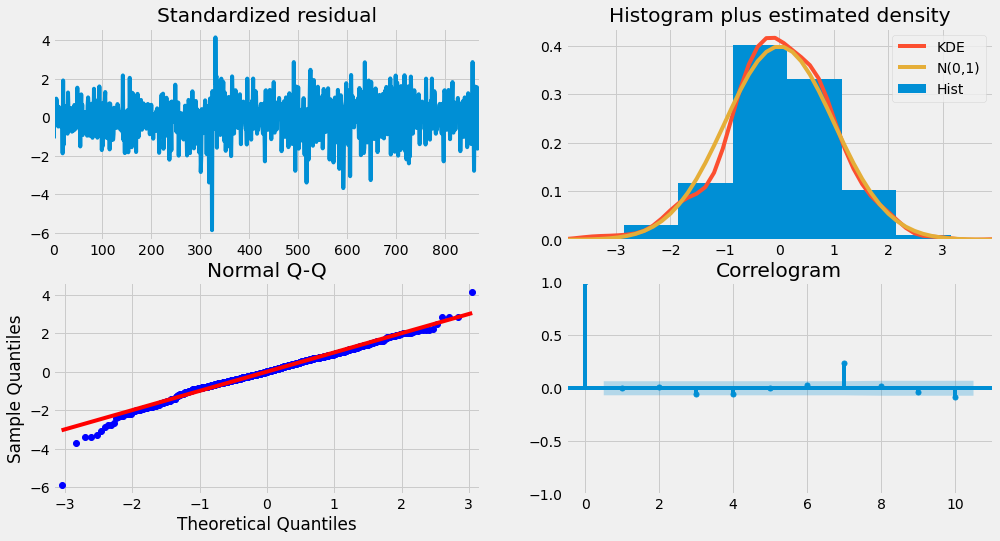

In [17]:
from pmdarima.arima import auto_arima
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
'''Jadi bagaimana menafsirkan diagnostik plot?

Kiri atas: Kesalahan residual tampaknya berfluktuasi di sekitar rata-rata nol dan memiliki varians yang seragam.

Kanan Atas: Plot kepadatan menunjukkan distribusi normal dengan rata-rata nol.

Kiri bawah: Semua titik harus tepat sejajar dengan garis merah. Setiap penyimpangan yang signifikan akan menyiratkan distribusi miring.

Kanan Bawah: Correlogram, alias, plot ACF menunjukkan kesalahan residual tidak autokorelasi. Setiap autokorelasi
akan menyiratkan bahwa ada beberapa pola dalam kesalahan residual yang tidak dijelaskan dalam model. Jadi,  perlu mencari lebih banyak X (prediktor) pada model.

Secara keseluruhan, tampaknya cocok.

Selanjutnya, buat model ARIMA dengan parameter optimal p, d dan q yang disediakan.

Jadi model Auto ARIMA memberikan nilai p,d, dan q masing-masing sebagai 1, 0 dan 2.

In [18]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,0,2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                              ARMA Model Results                              
Dep. Variable:                  berat   No. Observations:                  873
Model:                     ARMA(1, 2)   Log Likelihood                -121.124
Method:                       css-mle   S.D. of innovations              0.278
Date:                Mon, 10 Oct 2022   AIC                            252.247
Time:                        23:42:57   BIC                            276.107
Sample:                    01-04-2017   HQIC                           261.375
                         - 05-26-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           8.6571      0.127     68.028      0.000       8.408       8.906
ar.L1.berat     0.9811      0.007    137.071      0.000       0.967       0.995
ma.L1.berat    -0.6859      0.034    -20.156    

In [ ]:
'''memperkirakan/peramalan Berat pada dataset uji dengan menjaga tingkat kepercayaan 95%.'''

In [20]:
# Forecast
fc, se, conf = fitted.forecast(219, alpha=0.05)  # 95% conf

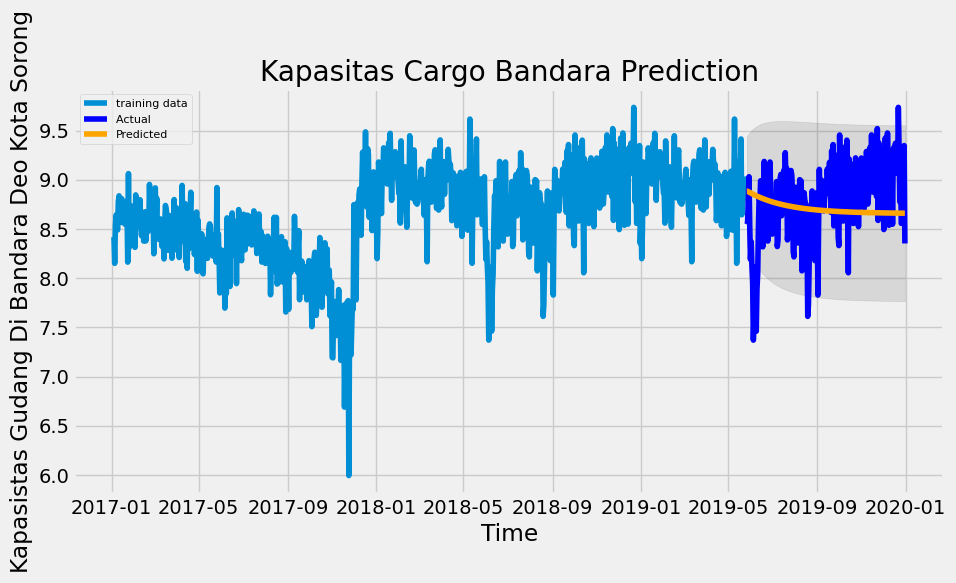

In [21]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual ')
plt.plot(fc_series, color = 'orange',label='Predicted')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Kapasitas Cargo Bandara Prediction')
plt.xlabel('Time')
plt.ylabel('Kapasistas Gudang Di Bandara Deo Kota Sorong')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
'''Seperti yang Kita lihat, model  melakukannya dengan sangat baik. 
 memeriksa metrik akurasi yang umum digunakan untuk menilai hasil perkiraan:

In [29]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae)) 
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))

MSE: 0.18729512466781462
MAE: 0.3449721743068426
RMSE: 0.43277606757746506


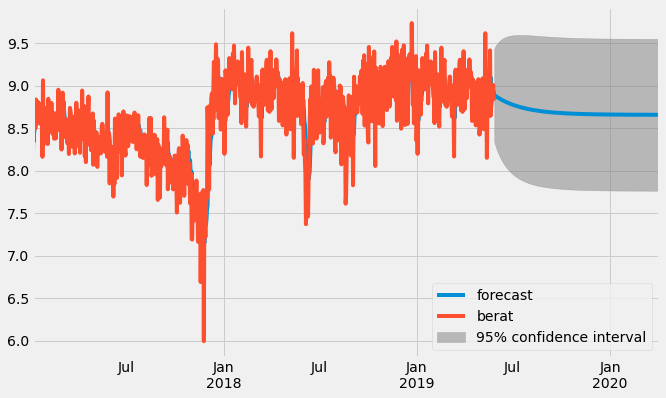

In [30]:
fitted.plot_predict(1,1185)  #3 bulan
x=fitted.forecast(steps=30)
# print(x)